#### üì• Librer√≠as:

In [14]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt

### üìå Parte 1: Preparaci√≥n de Datos y Desarrollo del Modelo

‚úÖ *Hemos descargado y guardado los datos en el archivo* `data/NVDA_10yr.csv`.  
El siguiente paso es normalizar la columna `Close` para preparar los datos para el modelo LSTM.


### üéπ Paso 2: Normalizaci√≥n de datos
Para preparar los datos para la red LSTM, normalizaremos la columna `Close` usando `MinMaxScaler`, escalando los valores entre 0 y 1.

Guardaremos tanto los datos normalizados como el objeto `scaler` para reutilizarlo m√°s adelante.

In [11]:
#  Cargar CSV con MultiIndex en columnas
df = pd.read_csv("data/NVDA_10yr.csv", header=[0, 1], index_col=0, parse_dates=True)

#  Eliminar MultiIndex: nos quedamos con el primer nivel del encabezado
df.columns = df.columns.get_level_values(0)

#  Normalizar la columna 'Close'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df[["Close"]])

#  Guardar el scaler para reutilizarlo despu√©s
joblib.dump(scaler, "data/close_price_scaler.save")

#  Agregar columna normalizada al DataFrame
df["Close_Scaled"] = scaled_close

#  Mostrar un preview de los datos normalizados
df[["Close", "Close_Scaled"]].head(10)

Price          Close  Close_Scaled
Date                              
2014-01-02  0.373906      0.000079
2014-01-03  0.369427      0.000049
2014-01-06  0.374377      0.000083
2014-01-07  0.380507      0.000124
2014-01-08  0.385694      0.000159
2014-01-09  0.371313      0.000062
2014-01-10  0.370841      0.000059
2014-01-13  0.362118      0.000000
2014-01-14  0.373434      0.000076
2014-01-15  0.377442      0.000103

 *La columna `Close` ha sido normalizada y guardamos el scaler en* `data/close_price_scaler.save`.  
Ahora toca hacer son **las secuencias de datos** para alimentar el modelo LSTM.


### ü©ª Paso 3: Crear secuencias para LSTM

Las redes requieren datos en forma de secuencias para capturar dependencias temporales. Usaremos un *look-back window* de **60 d√≠as**, lo que significa que el modelo utilizar√° los 60 precios anteriores para predecir el siguiente.

Tambi√©n dividiremos los datos en conjuntos de entrenamiento y prueba manteniendo el orden temporal (`shuffle=False`).

In [13]:
#  Definir funci√≥n para crear secuencias
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

#  Extraer la columna normalizada
scaled_data = df["Close_Scaled"].values.reshape(-1, 1)

#  Crear secuencias
look_back = 60
X, y = create_sequences(scaled_data, look_back=look_back)

#  Redimensionar X para LSTM: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

#  Mostrar shapes
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

#  Dividir en entrenamiento y prueba (80% / 20%, sin shuffle)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)


Shape de X: (2707, 60, 1)
Shape de y: (2707,)
Shape X_train: (2165, 60, 1)
Shape X_test : (542, 60, 1)


### üß†Paso 4: Construcci√≥n del modelo LSTM

Crearemos dos arquitecturas de red neuronal:

1. üîπ *Modelo sencillo:* una capa LSTM con Dropout para prevenir overfitting y una capa Dense de salida.
2. üîπ *Modelo robusto:* dos capas LSTM apiladas con Dropout y una capa Dense.

Usaremos `Keras` con TensorFlow como backend.

### üîπ Modelo 1: Sencillo (1 LSTM)

In [15]:
#  Construir el modelo sencillo
model_simple = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)  # Capa de salida
])

#  Compilar el modelo
model_simple.compile(optimizer="adam", loss="mean_squared_error")

#  Resumen del modelo
model_simple.summary()


/Users/carlosmoreno/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 50)             ‚îÇ        10,400 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 50)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ            51 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### üîπ Modelo 2: Robusto (2 LSTM)

In [16]:
# üì¶ Construir el modelo robusto
model_robust = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Capa de salida
])

# üõ† Compilar el modelo
model_robust.compile(optimizer="adam", loss="mean_squared_error")

# üìÉ Resumen del modelo
model_robust.summary()


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 60, 50)         ‚îÇ        10,400 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 60, 50)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, 50)             ‚îÇ        20,200 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 50)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            51 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

En el siguiente paso entrenaremos ambos modelos y compararemos sus predicciones con los valores reales.

### Paso 5: Entrenamiento de los modelos y predicci√≥n

Entrenaremos ambos modelos (sencillo y robusto) con los datos de entrenamiento durante 50 √©pocas. Posteriormente, generaremos las predicciones sobre el conjunto de prueba y desnormalizaremos los valores para compararlos con los precios reales.

In [17]:
# Entrenamiento del modelo sencillo
history_simple = model_simple.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Entrenamiento del modelo robusto
history_robust = model_robust.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
68/68 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 7ms/step - loss: 8.3542e-04 - val_loss: 0.0012
Epoch 2/50
68/68 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 7.9816e-05 - val_loss: 0.0015
Epoch 3/50
68/68 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 6.7418e-05 - val_loss: 0.0013
Epoch 4/50
68/68 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 5.6495e-05 - val_loss: 0.0021
Epoch 5/50
68/68 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 5.6215e-05 - val_loss: 0.0024
Epoch 6/50
68/68 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 4.1742e-05 - val_loss: 0.0014
Epoch 7/50
68/68 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 5.1236e-05 - val_loss: 0.0030
Epoch 8/50
68/68 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 3.9913

### Generar predicciones y desnormalizar

In [20]:
# Predicciones con cada modelo
y_pred_simple = model_simple.predict(X_test)
y_pred_robust = model_robust.predict(X_test)

# Desnormalizar los valores (revertir MinMaxScaler)
import joblib
scaler = joblib.load("data/close_price_scaler.save")

# Desnormalizar predicciones
y_pred_simple_rescaled = scaler.inverse_transform(y_pred_simple)
y_pred_robust_rescaled = scaler.inverse_transform(y_pred_robust)

# Desnormalizar precios reales
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step


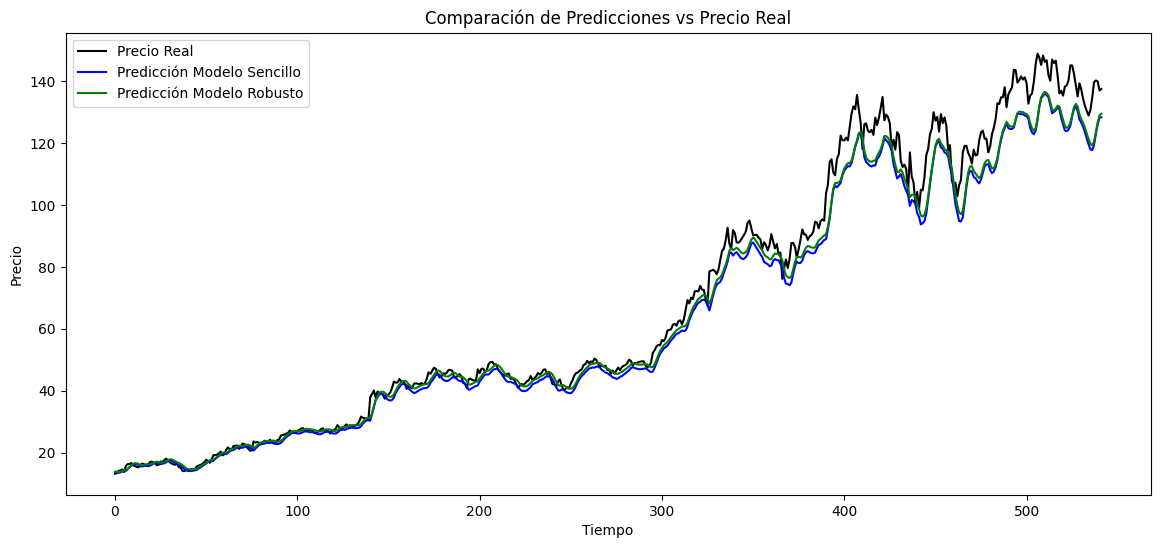

In [21]:
#  Gr√°fico de comparaci√≥n
plt.figure(figsize=(14, 6))

# Precios reales
plt.plot(y_test_rescaled, color="black", label="Precio Real")

# Modelo sencillo
plt.plot(y_pred_simple_rescaled, color="blue", label="Predicci√≥n Modelo Sencillo")

# Modelo robusto
plt.plot(y_pred_robust_rescaled, color="green", label="Predicci√≥n Modelo Robusto")

plt.title("Comparaci√≥n de Predicciones vs Precio Real")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()


üìå **Finding: Evaluaci√≥n de predicciones de los modelos LSTM**

En la visualizaci√≥n se observa que **ambos modelos (sencillo y robusto)** logran seguir de manera adecuada la tendencia general de los precios reales de NVIDIA a lo largo del periodo de prueba.  

üîπ El **modelo robusto** (2 capas LSTM) muestra predicciones **m√°s cercanas a los valores reales**, especialmente en los picos y valles. 

üîπ El **modelo sencillo** tiende a suavizar las variaciones, generando predicciones ligeramente m√°s atrasadas respecto a los cambios bruscos en los precios.  

    Aunque ambos modelos son efectivos, la arquitectura robusta tiene un mejor desempe√±o al capturar movimientos m√°s abruptos, lo cual podr√≠a traducirse en decisiones de trading m√°s acertadas.


### Paso 6: Backtesting de estrategias

Para evaluar el rendimiento pr√°ctico de los modelos, simularemos una estrategia de trading simple:
  
- **Estrategia LSTM:** Comprar cuando la predicci√≥n del pr√≥ximo precio sea mayor que el precio actual (se√±al de subida). Vender cuando la predicci√≥n sea menor que el precio actual (se√±al de bajada). 

- **Estrategia Buy & Hold:** Comprar una vez al inicio y mantener la posici√≥n durante todo el periodo.

In [31]:
#  Simulaci√≥n de estrategia de trading
def backtest_strategy(predictions, real_prices):
    """
    Simula una estrategia de trading:
    - Compra cuando la predicci√≥n futura > precio actual.
    - Vende cuando la predicci√≥n futura < precio actual.
    """
    returns = []
    position = 0  # 0 = no posici√≥n, 1 = comprado

    for i in range(1, len(real_prices)):
        if predictions[i] > real_prices[i-1] and position == 0:
            position = 1  # Comprar
        elif predictions[i] < real_prices[i-1] and position == 1:
            position = 0  # Vender

        # Calcular retorno diario
        daily_return = (real_prices[i] / real_prices[i-1] - 1) * position
        returns.append(daily_return)

    # Retorno acumulado
    cumulative_return = np.cumprod([1 + r for r in returns])
    return cumulative_return

#  Simular ambas estrategias
real_prices = y_test_rescaled.flatten()

# Estrategia LSTM Sencilla
returns_simple = backtest_strategy(y_pred_simple_rescaled.flatten(), real_prices)

# Estrategia LSTM Robusta
returns_robust = backtest_strategy(y_pred_robust_rescaled.flatten(), real_prices)

# Estrategia Buy & Hold
buy_hold = real_prices / real_prices[0]


 *Hemos simulado una estrategia de trading basada en predicciones LSTM y la comparamos con Buy & Hold.*  
El siguiente paso ser√° guardar los modelos y scaler para reutilizarlos posteriormente. Sin embargo, pensamos que es posible probarlo de una manera m√°s pr√°ctica. Hagamos un miniback tester con la finalidad de probar con un üí∞ `capital inicial` el desempe√±o de los modelos.


In [32]:
def mini_backtester(predictions, real_prices, capital_inicial=10000):
    """
    Simula una estrategia de trading simple:
    - Compra cuando la predicci√≥n futura > precio actual.
    - Vende cuando la predicci√≥n futura < precio actual.
    """
    capital = capital_inicial
    position = 0  # 0 = no posici√≥n, 1 = comprado
    shares = 0
    capital_history = []
    trade_signals = []  # Para registrar se√±ales (Buy/Sell)

    for i in range(1, len(real_prices)):
        price_today = real_prices[i]
        price_yesterday = real_prices[i-1]

        # Estrategia: comprar si la predicci√≥n sube
        if predictions[i] > price_yesterday and position == 0:
            shares = capital // price_today  # Comprar acciones enteras
            capital -= shares * price_today
            position = 1
            trade_signals.append(("Buy", i, price_today))

        # Estrategia: vender si la predicci√≥n baja
        elif predictions[i] < price_yesterday and position == 1:
            capital += shares * price_today  # Vender todas las acciones
            shares = 0
            position = 0
            trade_signals.append(("Sell", i, price_today))

        # Registrar el valor total del portafolio
        portfolio_value = capital + shares * price_today
        capital_history.append(portfolio_value)

    # Valor final si a√∫n hay posici√≥n abierta
    if position == 1:
        capital += shares * price_today
        trade_signals.append(("Sell", len(real_prices)-1, real_prices[-1]))
        shares = 0

    return np.array(capital_history), trade_signals


In [33]:
capital_history, trades = mini_backtester(
    preds=y_pred_robust_rescaled.flatten(),
    real_prices=y_test_rescaled.flatten(),
    initial_capital=1000
)

# Mostrar resumen de operaciones
for t in trades[-5:]:
    print(f"{t[0]} @ D√≠a {t[1]} | Precio: {t[2]:.2f} | Capital: {t[3]:.2f}")

print(f"\nCapital final: ${capital_history[-1]:.2f}")


TypeError: mini_backtester() got an unexpected keyword argument 'preds'

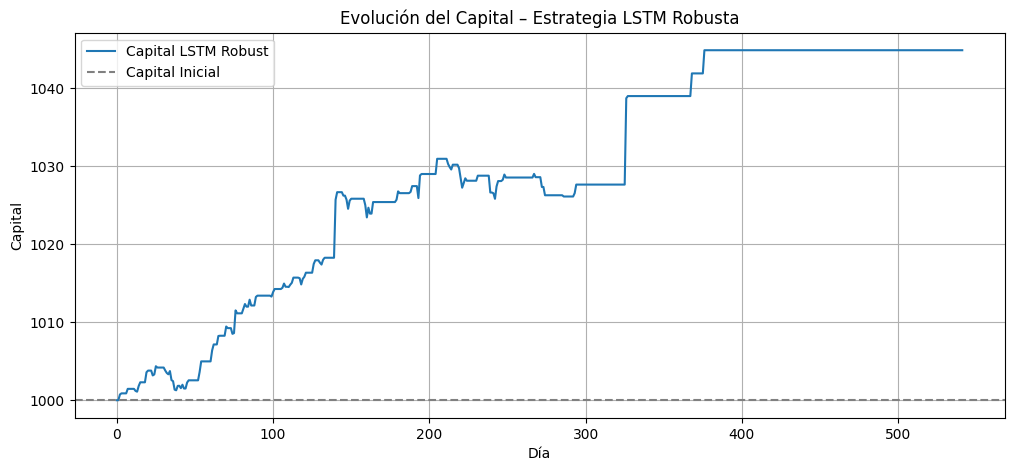

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(capital_history, label="Capital LSTM Robust")
plt.axhline(1000, color='gray', linestyle='--', label="Capital Inicial")
plt.title("Evoluci√≥n del Capital ‚Äì Estrategia LSTM Robusta")
plt.xlabel("D√≠a")
plt.ylabel("Capital")
plt.legend()
plt.grid(True)
plt.show()


### üìç Visualizaci√≥n Pro: Entradas y salidas en el precio

Graficaremos los precios reales y se√±alaremos las operaciones:  
üîµ Flechas hacia arriba para compras (Buy).  
üî¥ Flechas hacia abajo para ventas (Sell).  


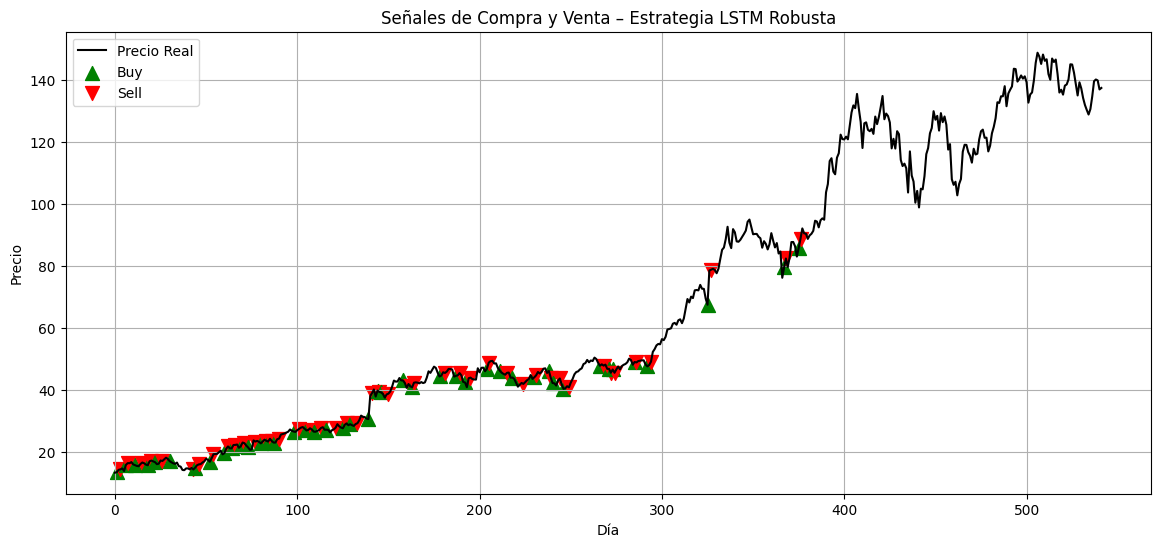

In [35]:
def plot_trades(real_prices, trades):
    plt.figure(figsize=(14, 6))
    plt.plot(real_prices, color="black", label="Precio Real")
    
    # Marcar las operaciones
    for t in trades:
        if t[0] == "Buy":
            plt.scatter(t[1], t[2], color="green", marker="^", s=100, label="Buy")
        elif t[0] == "Sell":
            plt.scatter(t[1], t[2], color="red", marker="v", s=100, label="Sell")
    
    plt.title("Se√±ales de Compra y Venta ‚Äì Estrategia LSTM Robusta")
    plt.xlabel("D√≠a")
    plt.ylabel("Precio")
    plt.legend(["Precio Real", "Buy", "Sell"])
    plt.grid(True)
    plt.show()

# üìä Visualizar operaciones sobre el precio
plot_trades(y_test_rescaled.flatten(), trades)


### üíµComparaci√≥n: LSTM vs Buy & Hold (Crecimiento de capital)

Compararemos el crecimiento acumulado del portafolio usando:  
- üìà **Estrategia LSTM (robusto)**: compra y venta seg√∫n las predicciones.  
- üìä **Buy & Hold**: comprar al inicio y mantener hasta el final.

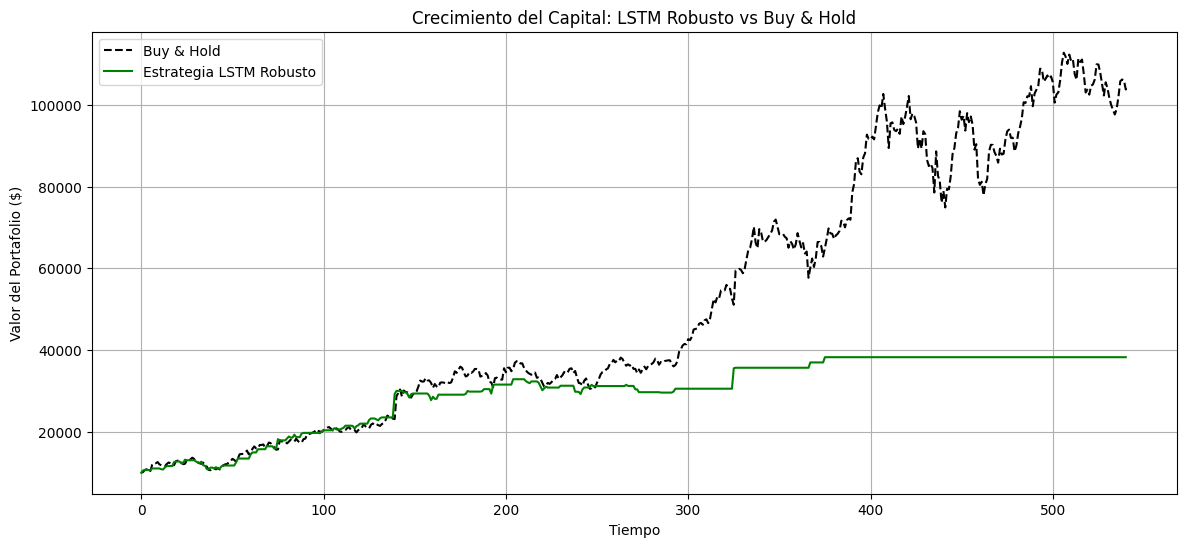

In [36]:
# üìà Buy & Hold
capital_initial = 10000
buy_hold_value = real_prices / real_prices[0] * capital_initial  # Normalizado al capital inicial

# üìà LSTM Robusto (corregido)
capital_history_robust, trade_signals_robust = mini_backtester(
    y_pred_robust_rescaled.flatten(),
    real_prices,
    capital_initial  # Pasar como argumento posicional
)

plt.figure(figsize=(14, 6))
plt.plot(buy_hold_value, label="Buy & Hold", color="black", linestyle="--")
plt.plot(capital_history_robust, label="Estrategia LSTM Robusto", color="green")

plt.title("Crecimiento del Capital: LSTM Robusto vs Buy & Hold")
plt.xlabel("Tiempo")
plt.ylabel("Valor del Portafolio ($)")
plt.legend()
plt.grid(True)
plt.show()



‚úÖ *El gr√°fico muestra la evoluci√≥n del capital para ambas estrategias a lo largo del tiempo. La l√≠nea discontinua negra representa la estrategia Buy & Hold, mientras que la l√≠nea verde corresponde a la estrategia basada en LSTM (robusto).*  
